<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_mmdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Quickstart
[MMDetection](https://github.com/open-mmlab/mmdetection)


## Introduction

This tutorial walk you through the different steps of training one of the MMDetection models supported in IceVision. We use either the Fridge Objects dataset or the PennFudan dataset. 

The IceVision Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai](https://github.com/fastai/fastai) library, and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) libraries.

For more information about how the fridge dataset as well as its corresponding parser check out the [IceData repository](https://github.com/airctic/icedata).

## Installing IceVision and IceData

In [ ]:
# !pip install icevision[all] icedata -q
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade -q

In [ ]:
!pip install -e icevision[all] --upgrade -q

In [ ]:
# !pip install icedata -q
!pip install git+git://github.com/airctic/icedata.git --upgrade -q

     |████████████████████████████████| 92kB 3.9MB/s 


## MMDetection Installation

In [ ]:
# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git

!pip install -e mmdetection -q

Cloning into 'mmdetection'...
remote: Enumerating objects: 16432, done.
remote: Total 16432 (delta 0), reused 0 (delta 0), pack-reused 16432
Receiving objects: 100% (16432/16432), 19.64 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (11385/11385), done.


## Check Pytorch installation

In [ ]:
import torch, torchvision
torch_version = torch.__version__
cuda_version = f"cu{torch.version.cuda.replace('.', '')}"
torch_version, cuda_version

('1.7.0', 'cu102')

## MMCV Full-Version Installation 

In [ ]:
mmcv_full_version = "1.2.5"
mmcv_full_url = f"https://download.openmmlab.com/mmcv/dist/{cuda_version}/torch{torch_version}/index.html" #e.g https://download.openmmlab.com/mmcv/dist/cu101/torch1.7.0/index.html 
mmcv_full_url

'https://download.openmmlab.com/mmcv/dist/cu102/torch1.7.0/index.html'

In [ ]:
!pip install mmcv-full=={mmcv_full_version} -f {mmcv_full_url} -U -q

     |████████████████████████████████| 24.1MB 1.6MB/s 
     |████████████████████████████████| 194kB 4.1MB/s 


In [ ]:
# Restart Runtime
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()

In [ ]:
import mmcv
print("MMCV: ", mmcv.__version__)

In [ ]:
# Check MMDetection installation
import mmdet
print("MMDetection: ", mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

MMDetection:  2.10.0
10.2
GCC 7.3


## If mmdet is not recognized, Restart Runtime from the "Runtime Menu" 

## Imports

In [ ]:
from icevision.all import *

## MMDetection Models Information

models_info contain all the necessary configuration information to build an MMDetection model. That includes:

- 'model_name'
- 'model_type'
- 'cfg_filepath'
- 'weights_url'

## Select a Model to train

You can select one of the following models: "retinanet", "fcos", "faster_rcnn", "mask_rcnn"

In [ ]:
model_type = models.mmdet.retinanet

## Datasets :

- For Object Detection the Fridge Object Dataset will be used
- For Mask Detection the PennFudan Dataset will be used



In [ ]:
data_dir = icedata.fridge.load_data()
parser = icedata.fridge.parser(data_dir)

  0%|          | 0/20380998 [00:00<?, ?B/s]

In [ ]:
train_records, valid_records = parser.parse()

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:134


In [ ]:
train_records[0]

BaseRecord

common: 
	- Image size ImgSize(width=499, height=666)
	- Filepath: /root/.icevision/data/fridge/odFridgeObjects/images/96.jpg
	- Image: None
	- Image ID: 124
detection: 
	- BBoxes: [<BBox (xmin:86, ymin:244, xmax:426, ymax:493)>]
	- Labels: [2]

In [ ]:
presize, size = 512, 384

train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [ ]:
parser.class_map

<ClassMap: {'background': 0, 'milk_bottle': 1, 'carton': 2, 'can': 3, 'water_bottle': 4}>

### Visualization
Showing some images

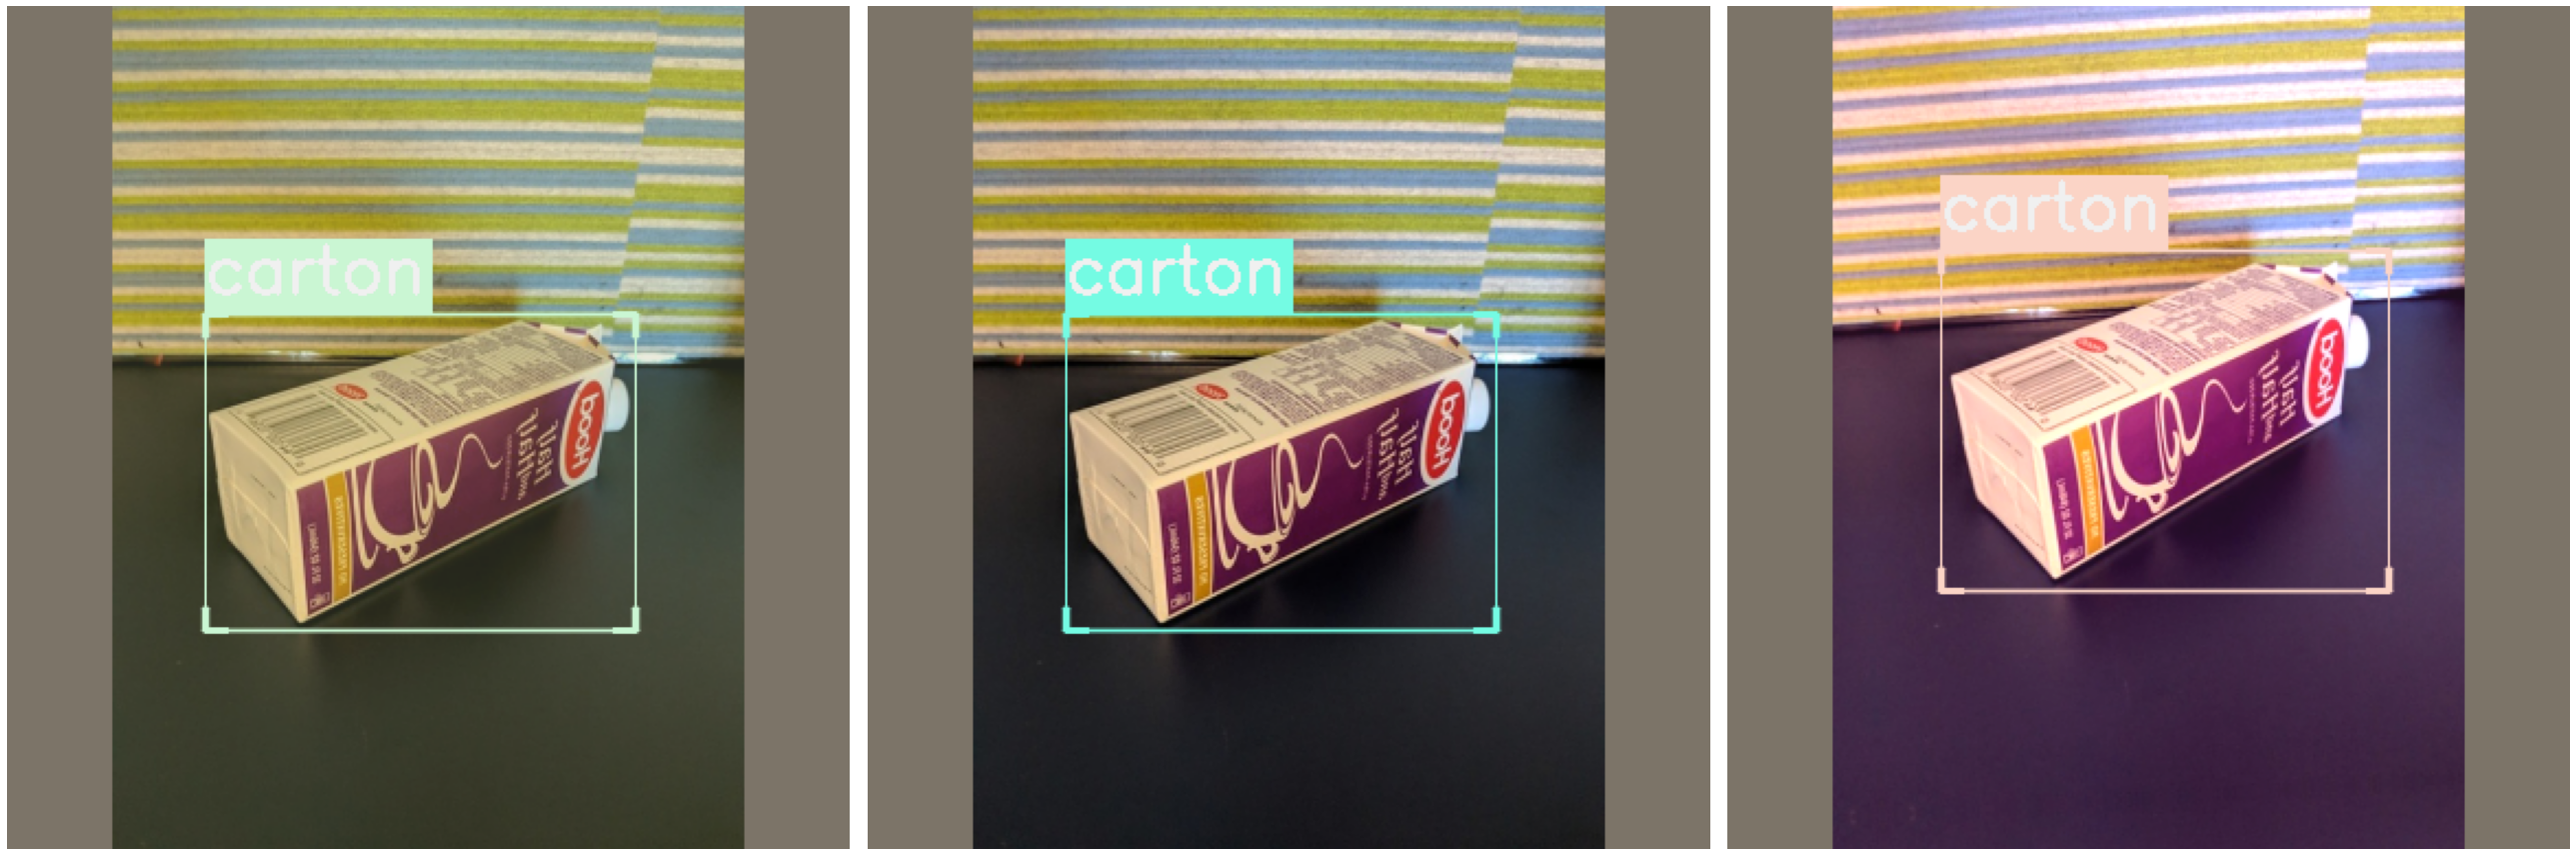

In [ ]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=parser.class_map)

## Creating a Model

In [ ]:
# Use autocompletion to check out all the available pretrained backbones (e.g. retinanet has 10 of them)
backbone = model_type.backbones.r50_fpn_1x

In [ ]:
model = model_type.model(backbone=backbone, num_classes=len(parser.class_map))

  0%|          | 0/152149505 [00:00<?, ?B/s]

The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([36, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([36]).


## Training

## Training - Fastai

In [ ]:
# Fastai trainable_params splitter
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, splitter=fastai.trainable_params)


# Using param_groups (model splitter)
# - 6 groups for OneStageDetector model (fcos, retinanet)
# - 7 groups for TwoStageDetector model (faster_rcnn, mask_rcnn, sparse_rcnn)

#learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model)


SuggestedLRs(lr_min=6.399789708666503e-05, lr_steep=8.191461529349908e-05)

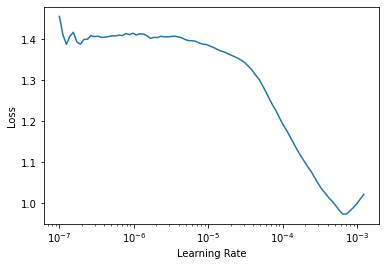

In [ ]:
# learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
learn.lr_find(end_lr=0.005)

In [ ]:
learn.fine_tune(20, 4e-5)

epoch,train_loss,valid_loss,time
0,1.330726,1.163189,00:06


epoch,train_loss,valid_loss,time
0,1.193407,1.078116,00:05
1,1.129870,0.943164,00:05
2,1.041448,0.741737,00:05
3,0.928491,0.567307,00:05
4,0.809053,0.400839,00:05
5,0.705078,0.325770,00:05
6,0.617037,0.277483,00:05
7,0.543727,0.227804,00:05
8,0.477586,0.210975,00:05
9,0.429538,0.176158,00:05


## Training - Pytorch-Lightning

In [ ]:
class LitModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-5)
    
lit_model = LitModel(model)
trainer = pl.Trainer(max_epochs=10, gpus=1, num_sanity_val_steps=0, check_val_every_n_epoch=1)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [ ]:
lr_finder = trainer.tuner.lr_find(lit_model, train_dl, valid_dl, max_lr=0.005)


  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 36.4 M
------------------------------------
36.2 M    Trainable params
225 K     Non-trainable params
36.4 M    Total params
145.568   Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


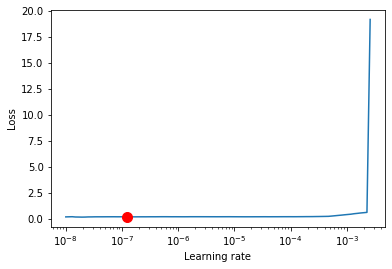

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
trainer.fit(lit_model, train_dl, valid_dl)

## Show Results

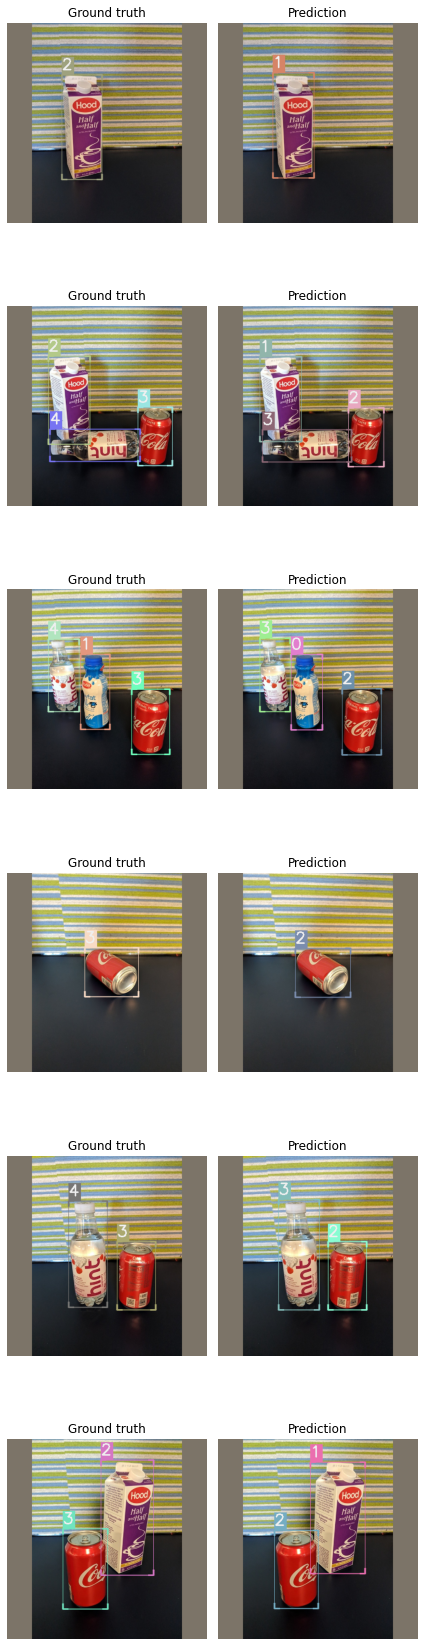

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

## Inference


In [ ]:
preds = model_type.predict(model, valid_ds)

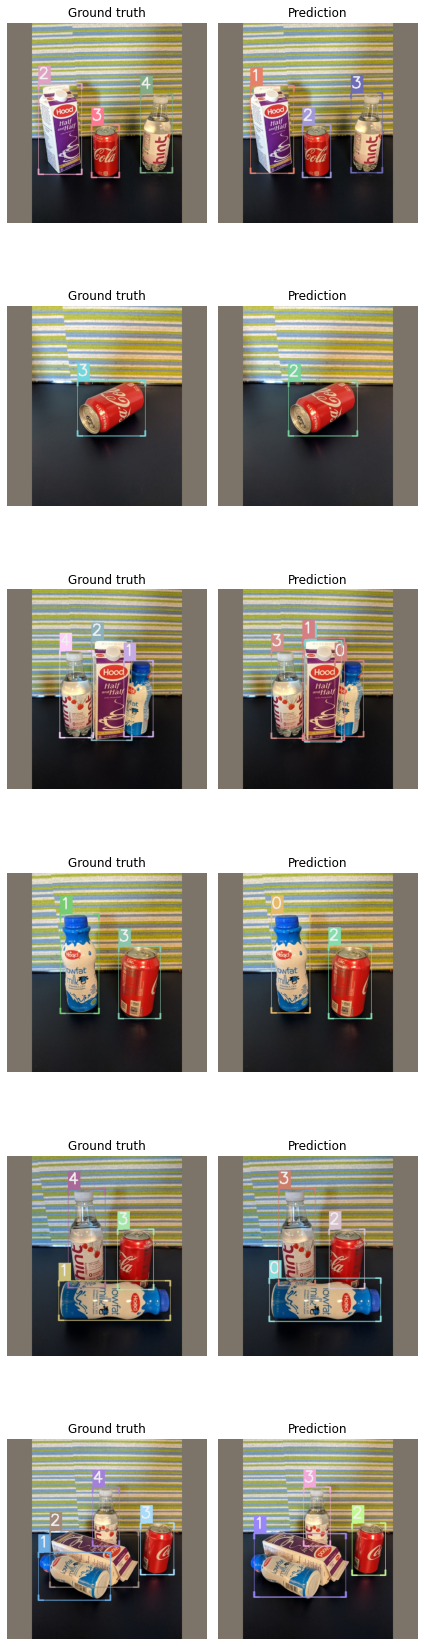

In [ ]:
show_preds(
    preds=preds[:6],
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).